In [1]:
import os
import math

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

In [2]:
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

In [3]:
import sys
sys.path.append('../')

In [4]:
isess = tf.InteractiveSession()

In [5]:
%matplotlib inline

# Analyse Xception model

Weights distribution and so on!

In [6]:
from nets import xception
from preprocessing import inception_preprocessing

ckpt_filename = '../checkpoints/xception_weights_tf_dim_ordering_tf_kernels.ckpt'

In [7]:
# Input placeholder.
img_size = xception.xception.default_image_size
img_input = tf.placeholder(tf.float32, shape=(img_size, img_size, 3))
image_4d = tf.expand_dims(img_input, 0)

# Define the SSD model.
reuse = True if 'xception_net' in locals() else None
with slim.arg_scope(xception.xception_arg_scope()):
    r = xception_net = xception.xception(image_4d, is_training=False, reuse=reuse)

In [8]:
# Initialize variables and restore Xception ckpt.
init_op = tf.global_variables_initializer()
isess.run(init_op)
init_op = tf.local_variables_initializer()
isess.run(init_op)

saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

In [9]:
def get_pointwise_weights(scope='xception/block5/sepconv1', bn_norm=True):
    """Get the pointwise weights in depthwise convolution.
    """
    pname = 'pointwise_weights'
    mname = 'BatchNorm/moving_mean'
    vname = 'BatchNorm/moving_variance'
    with tf.variable_scope(scope, reuse=True):
        # Get numpy values.
        pweights = tf.get_variable(pname).eval()
        bn_mean = tf.get_variable(mname).eval()
        bn_variance = tf.get_variable(vname).eval()
        # Re-normalise components using BN coefficients.
        pweights = np.squeeze(pweights)
        if bn_norm:
            pweights = pweights / bn_variance
        # Prefer transpose format: nb lines = nb outputs
        return np.transpose(pweights), bn_mean / bn_variance

In [103]:
def pweights_percentiles(pweights, q=75.):
    """Compute percentiles on pointwise weight matrix. 
    """
    perc = np.percentile(pweights, q=q, axis=1)
    return perc
    
def pweights_activations(pweights, q=75.):
    """Number of activations per entry.
    """
    perc = np.percentile(np.abs(pweights), q=q, axis=0)
    activ = np.float32(np.abs(pweights) > perc)
    activ_out = np.sum(activ, axis=1)
    activ_in = np.sum(activ, axis=0)
    return activ, activ_out
    

In [106]:
pweights, pmean = get_pointwise_weights('xception/block6/sepconv1')
print(pweights.shape)

perc = np.percentile(np.abs(pweights), q=75., axis=0)
print(perc.shape)

activ_mat75, activ75 = pweights_activations(pweights, q=75.)
activ_mat80, activ80 = pweights_activations(pweights, q=80.)
activ_mat85, activ85 = pweights_activations(pweights, q=85.)
activ_mat90, activ90 = pweights_activations(pweights, q=90.)
activ_mat95, activ95 = pweights_activations(pweights, q=95.)

print(activ75.shape)


(728, 728)
(728,)
(728,)


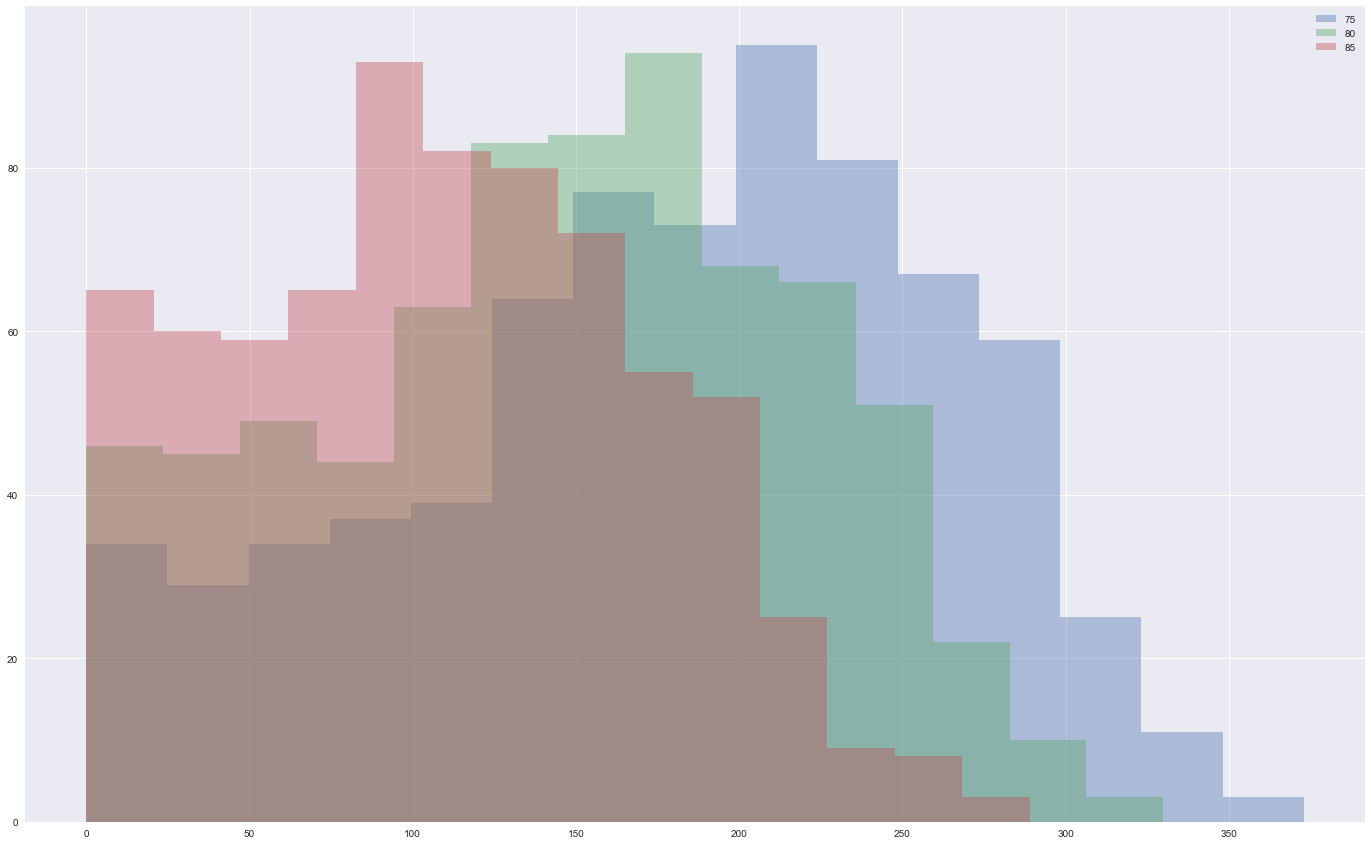

In [122]:
f, axes = plt.subplots(1, 1, figsize=(24, 15))
# f.tight_layout()
    
sns.distplot(activ75, label='75', kde=False)
sns.distplot(activ80, label='80', kde=False)
sns.distplot(activ85, label='85', kde=False)
# sns.distplot(activ90, label='90')
# sns.distplot(activ95)

plt.legend()
plt.show()

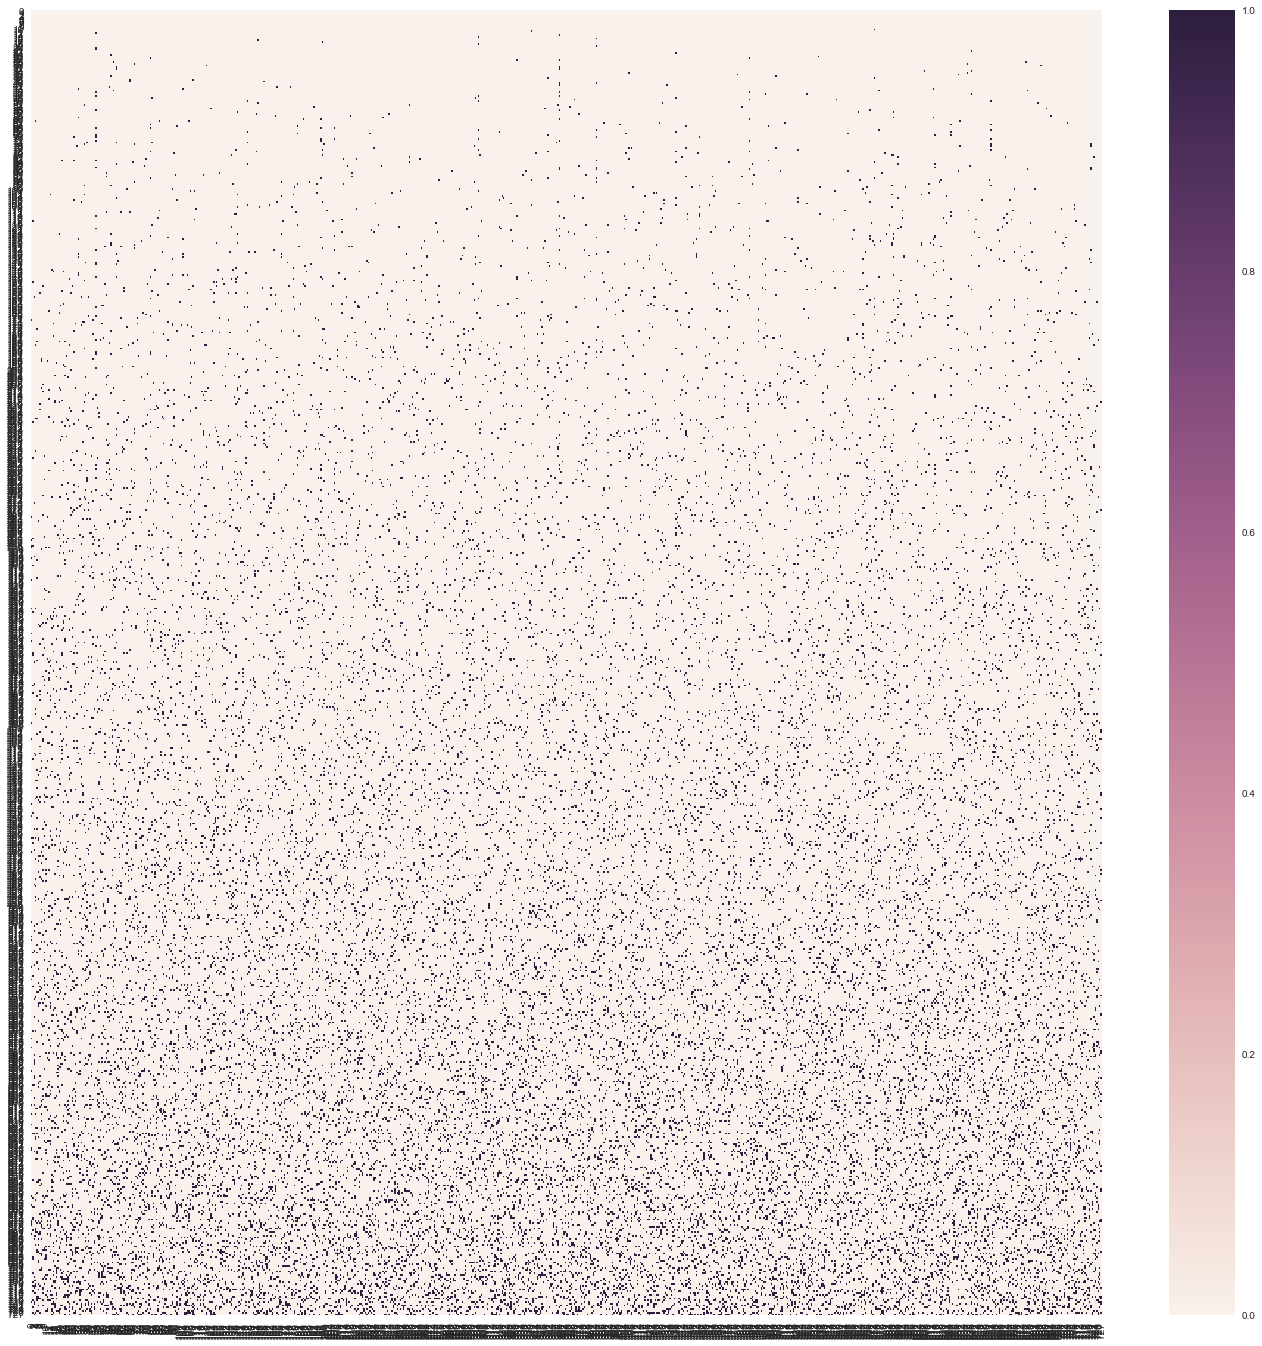

In [125]:
idx_sort = np.argsort(activ95)

activ_sort95 = activ_mat95[idx_sort]
f, axes = plt.subplots(1, 1, figsize=(24, 24))
sns.heatmap(activ_sort95)

plt.show()

In [ ]:
activ_sort85 

In [115]:
# f, axes = plt.subplots(1, 1, figsize=(24, 15))
# # f.tight_layout()


# mask = activ85 > 200 
# activ_mask = activ_mat85 * np.expand_dims(mask, axis=1)

# sns.distplot(np.sum(activ_mask, axis=1), label='85', kde=False)
# # sns.distplot(activ_in80, label='80', kde=False)
# # sns.distplot(activ_in85, label='85', kde=False)
# # sns.distplot(activ_in90, label='90')
# # sns.distplot(activ95)

# plt.legend()
# plt.show()

In [68]:
activ = activ80

def activ_stats(activ):
    print('Mean:', np.mean(activ))
    print('Max:', np.max(activ))
    print('Zero activation:', np.sum(activ==0.))
    print()
    
activ_stats(activ75)
activ_stats(activ80)
activ_stats(activ85)

Mean: 182.0
Max: 392.0
Zero activation: 0

Mean: 146.0
Max: 362.0
Zero activation: 2

Mean: 110.0
Max: 309.0
Zero activation: 5



In [13]:
with tf.variable_scope('xception/block5/sepconv1', reuse=True):
    v = tf.get_variable('pointwise_weights')
    v = tf.get_variable('BatchNorm/moving_variance')
    
    print(v.eval().shape)

(728,)


In [14]:
0.4237206

0.4237206

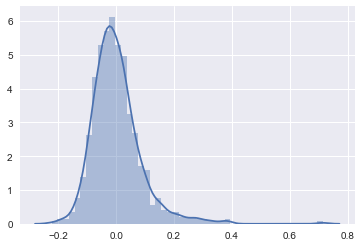

In [15]:
sns.distplot(pweights[:, 210])
plt.show()